In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def cm2inch(value):
    return value/2.54

In [3]:
plotsize_subplots = (cm2inch(19),cm2inch(3.5))
#plotsize_subplots = (16,3)

#plotsize_mem_conn_subplots = (cm2inch(17),cm2inch(7))

fontsize_axis = 7
fontsize_labels = 7
fontsize_legends = 4

#print(plt.rcParams.keys())

plt.rcParams.update({'figure.figsize': plotsize_subplots,
                     'axes.titlesize': fontsize_labels,
                     'axes.labelsize': fontsize_labels,
                     'ytick.labelsize': 'small'})

# Functions

In [77]:
def calculate_T_conn_and_memory(df):
    """Calculate T_conn and memory_per_rank"""
    df['T_bld_xn'] = df['T_conns_min'] + df['T_ini_max']
    df['T_bld_nx'] = df['T_conns_max'] + df['T_ini_min']
    df['Conn. Total']   = df[['T_bld_xn', 'T_bld_nx']].min(axis=1)
    df['Conn. Creation (min)'] = df['T_conns_min']
    df['Conn. Exchange (min)'] = df['T_ini_min']

    
    if 'NUM_VPS' not in list(df):
        df['N_VP'] = df['NUMBER_OF_NODES']*df['TASKS_PER_NODE']*df['THREADS_PER_TASK']
    else:
        df['N_VP'] = df['NUM_VPS']
    if np.isnan(df['VSize_sum']).all():
        df['VSize_sum'] = df['VSize_ini_sum']
    if 'VSize_mem_sum' not in list(df) and 'VSize_nodes_sum' not in list(df): #MAM
        df['VSize_mem_sum'] = df['VSize_net_sum']
        df['VSize_nodes_sum'] = [0]*len(df)
    
    # Er denne konverteringen riktig?
    # Vi har MiB = 1024**2 B
    # Verdien vi får fra NEST er i KiB (http://www.nest-simulator.org/helpindex/sli/memory_thisjob.html)
    
    df['connections'] = ((df['VSize_mem_sum']-df['VSize_nodes_sum'])/df['N_VP'])*1024/1024**3
    df['ini'] = ((df['VSize_ini_sum']-df['VSize_mem_sum'])/df['N_VP'])*1024/1024**3
    df['other'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3 - df['connections'] - df['ini']
    df['Memory per Rank'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3
    
    if False:
        print(df['connections'])
        print(df['ini'])
        print(df['other'])
        print(df['connections'] + df['ini'] + df['other'])
        print(df['memory_per_rank'])

        print((df['connections'] + df['ini'] + df['other']) == df['memory_per_rank'])

    return df

In [72]:
def time_per_connection(df):
    df['Total Conn. Time per Conn.'] = df['Conn. Total']/df['N_conns_sum'] * 1e9
    df['Conn. Creation Time per Conn. (min)'] = df['Conn. Creation (min)']/df['N_conns_sum'] * 1e9
    df['Conn. Exchange Time per Conn. (min)'] = df['Conn. Exchange (min)']/df['N_conns_sum'] * 1e9
    return df

In [112]:
def plot_results(df, name, plot_T_sim=False, index=None, legend_loc='lower right', rot=45):
    ncols = 4
    values = ['Conn. Exchange (min)', 'Conn. Creation (min)', 'Conn. Total']
    
    if not index:
        index='N_VP'
    
    if plot_T_sim:
        values += ['T_sim']
        ncols += 1
    
    df_p = pd.pivot_table(df, index=[index], values=values)
    df_mem = pd.pivot_table(df, index=[index], values=['connections', 'ini', 'other'])
    
    # Make subplots
    fig, axes = plt.subplots(nrows=1, ncols=ncols)
    
    df_p.plot(kind='bar', capsize=4, subplots=True, legend=False, ax=axes[:ncols-1], fontsize=fontsize_axis,
              rot=rot, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
    df_mem.plot(kind='bar', capsize=4, stacked=True, legend=True, ax=axes[ncols-1],
                fontsize=fontsize_axis, rot=rot, color=['purple', 'pink', 'red'])
    
    plt.legend(labels=('Connections', 'Exchange', 'Other'), fontsize=6, loc=legend_loc)
    
    plt.subplots_adjust(wspace=0.4)
    
    # dashed line
    for i, val_name in enumerate(list(df_p)):
        axes[i].axhline(y=df[val_name][0], linestyle='--', color='grey')
        axes[i].set_xlabel(index)
    
    # y-axes labels
    axes[0].set_ylabel('Time [s]')
    
    # memory plot
    axes[ncols-1].axhline(y=df['Memory per Rank'][0], linestyle='--', color='grey')
    axes[ncols-1].set_ylabel('Memory [GiB]')
    axes[ncols-1].set_title('Memory per Rank')
    axes[ncols-1].set_xlabel(index)
    axes[ncols-1].ticklabel_format(style='sci', scilimits=(-3,2), axis='y', useMathText=False)
    axes[ncols-1].get_yaxis().get_offset_text().set_position((-0.2,0))
    
    fig.savefig(name, bbox_inches='tight')
    
    df_p['connections'] = df_mem['connections']
    df_p['ini'] = df_mem['ini']
    df_p['other'] = df_mem['other']
    return df_p

In [104]:
def plot_compare(df, name, values=None, index=None, legend_loc='lower right', rot=45):
    """Plot times for different cases"""
    
    if not values:
        values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per Rank']
    if not index:
        index='N_VP'
    df_p = pd.pivot_table(df, index=index, columns='Case', values=values)


    # Make subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(values))

    for indx, val_name in enumerate(values):
        df_p[val_name].plot(kind='bar', ax = axes[indx], title=val_name, fontsize=fontsize_axis, rot=rot)
        axes[indx].legend(fontsize=fontsize_legends, loc=legend_loc)

    plt.subplots_adjust(wspace=0.4)

    # y-axis labels
    if 'Conn. Creation Time per Conn. (min)' in values:  
        axes[0].set_ylabel('Time [ns]')  # Not safe..
    else:
        axes[0].set_ylabel('Time [s]')
    if 'Memory per Rank' in values:
        # Assume memory is last entry in values
        axes[len(values) - 1].set_ylabel('Memory [GiB]')

    # x-axis labels
    for ax in axes:
        ax.set_xlabel(index)

    fig = plt.gcf()
    fig.savefig(name, bbox_inches='tight')
    
    return df_p

In [6]:
def save_table_latex(text, name):
    f = open(name, "w")
    f.write(text)
    f.close()

# FIGURES

## HPC_benchmark

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,54.30,42.19,99.81,2.743245,0.019534,0.055616
72,53.72,42.97,102.35,2.743245,0.024010,0.053295
144,54.19,44.75,105.35,2.743245,0.109460,0.053315
288,53.67,48.82,109.34,2.743245,0.114370,0.053327
576,52.43,60.34,120.57,2.743245,0.240082,0.053680
1152,52.39,79.09,139.73,2.743083,0.576400,0.054545


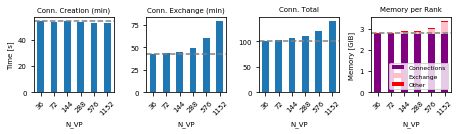

In [73]:
hpc_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s20.csv')

hpc_t6_s20 = calculate_T_conn_and_memory(hpc_t6_s20)
hpc_t6_s20_p = plot_results(hpc_t6_s20, 'benchmark_figures/hpc_benchmark.pdf', plot_T_sim=False)

save_table_latex(hpc_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_table.txt')
hpc_t6_s20_p

## HPC delay 0.1 - 50.

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,53.56,45.38,103.50,1.930745,0.392907,0.051058
72,51.74,46.95,107.41,1.930745,0.392907,0.053295
144,52.82,46.63,105.05,1.930745,0.394128,0.053315
288,52.01,50.14,111.17,1.930745,0.477530,0.053327
576,52.04,66.64,128.82,1.951579,0.459646,0.053680
1152,52.05,85.56,147.11,1.993083,0.460135,0.054545


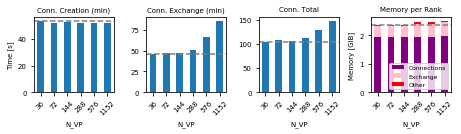

In [115]:
hpc_delay_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s20_delays.csv')

hpc_delay_t6_s20 = calculate_T_conn_and_memory(hpc_delay_t6_s20)
hpc_delay_t6_s20_p = plot_results(hpc_delay_t6_s20, 'benchmark_figures/hpc_benchmark_diff_delays.pdf')

save_table_latex(hpc_delay_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_diff_delays_table.txt')
hpc_delay_t6_s20_p

## HPC static, delay 0.1-50.

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,53.56,45.38,103.50,1.930745,0.392907,0.051058
72,51.74,46.95,107.41,1.930745,0.392907,0.053295
144,52.82,46.63,105.05,1.930745,0.394128,0.053315
288,52.01,50.14,111.17,1.930745,0.477530,0.053327
576,52.04,66.64,128.82,1.951579,0.459646,0.053680
1152,52.05,85.56,147.11,1.993083,0.460135,0.054545


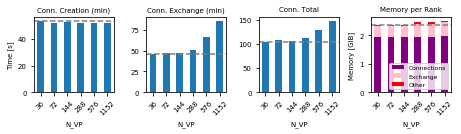

In [114]:
hpc_static_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s20_static_delays.csv')

hpc_static_t6_s20 = calculate_T_conn_and_memory(hpc_static_t6_s20)
hpc_static_t6_s20_p = plot_results(hpc_static_t6_s20, 'benchmark_figures/hpc_benchmark_static_diff_delays.pdf')

save_table_latex(hpc_static_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_static_diff_delays_table.txt')
hpc_static_t6_s20_p

## HPC Split into many `Connect` calls

Constant number of Connect calls

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,93.72,43.75,140.69,2.743245,0.018721,0.058383
72,95.04,44.08,141.95,2.743245,0.038740,0.127677
144,97.74,45.64,149.15,2.743245,0.103275,0.231606
288,102.46,48.82,160.06,2.743245,0.104300,0.458369
576,112.52,57.72,178.35,2.743245,0.181957,0.399136
1152,133.32,77.62,219.40,2.743083,0.553613,0.257282


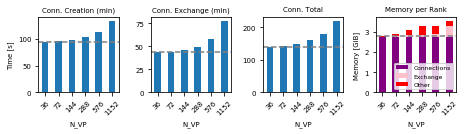

In [78]:
hpc_split_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s20_split.csv')

hpc_split_t6_s20 = calculate_T_conn_and_memory(hpc_split_t6_s20)
hpc_split_t6_s20_p = plot_results(hpc_split_t6_s20, 'benchmark_figures/hpc_benchmark_split.pdf', plot_T_sim=False)

save_table_latex(hpc_split_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_split_table.txt')
hpc_split_t6_s20_p

## HPC split into many Connect calls, increasing number of NBLOCKS

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,93.72,43.51,141.45,2.743245,0.016279,0.057569
72,231.57,43.54,289.88,2.743245,0.040368,0.125398
144,753.47,42.66,847.58,2.826579,0.019128,0.214502
288,2744.99,44.27,3124.88,2.933350,0.116690,0.336835
576,NaN,NaN,NaN,NaN,NaN,NaN
1152,NaN,NaN,NaN,NaN,NaN,NaN


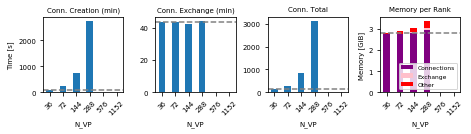

In [79]:
hpc_split_increase_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s20_split_increase.csv')

hpc_split_increase_t6_s20 = calculate_T_conn_and_memory(hpc_split_increase_t6_s20)
hpc_split_increase_t6_s20_p = plot_results(hpc_split_increase_t6_s20,
                                           'benchmark_figures/hpc_benchmark_split_increase.pdf', plot_T_sim=False)

save_table_latex(hpc_split_increase_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_split_increase_table.txt')
hpc_split_increase_t6_s20_p

## Comparing different cases from above

Conn. Creation (min)                      Conn. Exchange (min)  \
Case              Default Random delay   Split              Default   
N_VP                                                                  
36                  54.30        53.56   93.72                42.19   
72                  53.72        51.74   95.04                42.97   
144                 54.19        52.82   97.74                44.75   
288                 53.67        52.01  102.46                48.82   
576                 52.43        52.04  112.52                60.34   
1152                52.39        52.05  133.32                79.09   

                         Conn. Total                      Memory per Rank  \
Case Random delay  Split     Default Random delay   Split         Default   
N_VP                                                                        
36          45.38  43.75       99.81       103.50  140.69        2.818396   
72          46.95  44.08      102.35       107.41  141.95        2.820551   
144         46.63  45.64      105.35       105.05  149.15        2.906020   
288         50.14  48.82      109.34       111.17  160.06        2.910942   
576         66.64  57.72      120.57       128.82  178.35        3.037008   
1152        85.56  77.62      139.73       147.11  219.40        3.374027   

                             
Case Random delay     Split  
N_VP                         
36       2.374711  2.820349  
72       2.376948  2.909662  
144      2.378188  3.078126  
288      2.461602  3.305914  
576      2.464905  3.324338  
1152     2.507762  3.553978

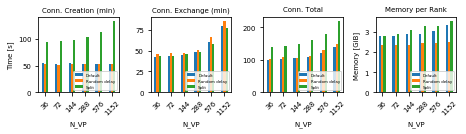

In [80]:
hpc_t6_s20['Case'] = ['Default'] * len(hpc_t6_s20)
hpc_delay_t6_s20['Case'] = ['Random delay'] * len(hpc_delay_t6_s20)
hpc_split_t6_s20['Case'] = ['Split'] * len(hpc_split_t6_s20)

hpc_cases = pd.concat([hpc_t6_s20, hpc_delay_t6_s20, hpc_split_t6_s20])

hpc_cases_p = plot_compare(hpc_cases, 'benchmark_figures/hpc_cases.pdf')
save_table_latex(hpc_cases_p.to_latex(), 'latex_tables/hpc_cases_table.txt')

hpc_cases_p

## HPC many connections per neuron
For comparison with population model

Important:
- N_nrns ~ 500 000 * NUMBER_OF_NODES
- N_conns_sum ~ 2 500 000 000 * NUMBER_OF_NODES

0     2498000500
1     4996000000
2     9991999000
3    19983997000
4    39967993000
5    79935985000
Name: N_conns_sum, dtype: int64
0      499500
1      999000
2     1998000
3     3996000
4     7992000
5    15984000
Name: N_nrns, dtype: int64


,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,55.78,49.72,110.99,2.7229,0.045869,0.067822
72,55.91,53.33,118.45,2.7229,0.317873,0.070221
144,55.52,54.99,121.10,2.7229,0.168870,0.070241
288,55.37,65.72,130.18,2.7229,0.312809,0.070252
576,54.80,96.50,161.45,2.7229,0.653931,0.070606
1152,54.48,156.48,221.62,2.7229,0.771078,0.071308


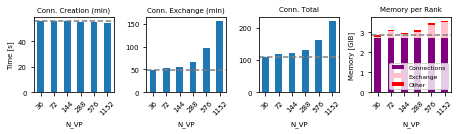

In [113]:
hpc_pop_comp = pd.read_csv('benchmark_results/hpc_pop_comp_benchmark_conn_sort_update_daint_t6_s44.csv')

hpc_pop_comp = calculate_T_conn_and_memory(hpc_pop_comp)

hpc_pop_comp_p = plot_results(hpc_pop_comp, 'benchmark_figures/hpc_benchmark_many_neurons.pdf')

save_table_latex(hpc_pop_comp_p.to_latex(), 'latex_tables/hpc_benchmark_many_neurons_table.txt')

print(hpc_pop_comp['N_conns_sum'])
print(hpc_pop_comp['N_nrns'])
hpc_pop_comp_p

## Population model

0     2500000000
1     5000000000
2    10000000000
3    20000000000
4    40000000000
5    80000000000
Name: N_conns_sum, dtype: int64
0      500000
1     1000000
2     2000000
3     4000000
4     8000000
5    16000000
Name: N_nrns, dtype: int64


,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,44.25,39.58,86.77,1.982666,0.095207,0.062289
72,44.43,40.50,88.60,1.978109,0.139478,0.068432
144,46.16,41.46,91.95,1.978109,0.220167,0.068452
288,48.49,43.75,95.33,1.978109,0.124685,0.068463
576,53.36,54.05,110.80,1.978109,0.398448,0.068817
1152,64.57,96.74,172.28,1.978109,0.443953,0.069519


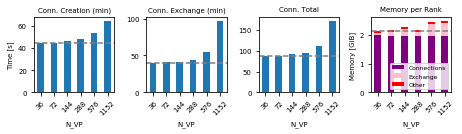

In [82]:
population = pd.read_csv('benchmark_results/population_model_conn_sort_update_daint_t6.csv')

population = calculate_T_conn_and_memory(population)
population_p = plot_results(population, 'benchmark_figures/population_model.pdf', plot_T_sim=False)

save_table_latex(population_p.to_latex(), 'latex_tables/population_model_table.txt')

print(population['N_conns_sum'])
print(population['N_nrns'])
population_p

## HPC benchmark vs HPC benchmark with many synapses per neuron

Conn. Creation (min)               Conn. Exchange (min)                \
Case              Default many synapses              Default many synapses   
N_VP                                                                         
36                  54.30         55.78                42.19         49.72   
72                  53.72         55.91                42.97         53.33   
144                 54.19         55.52                44.75         54.99   
288                 53.67         55.37                48.82         65.72   
576                 52.43         54.80                60.34         96.50   
1152                52.39         54.48                79.09        156.48   

     Conn. Total               Memory per Rank                
Case     Default many synapses         Default many synapses  
N_VP                                                          
36         99.81        110.99        2.818396      2.836591  
72        102.35        118.45        2.820551      3.110994  
144       105.35        121.10        2.906020      2.962012  
288       109.34        130.18        2.910942      3.105962  
576       120.57        161.45        3.037008      3.447438  
1152      139.73        221.62        3.374027      3.565286

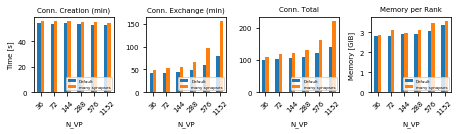

In [83]:
hpc_t6_s20['Case'] = ['Default'] * len(hpc_t6_s20)
hpc_pop_comp['Case'] = ['many synapses'] * len(hpc_pop_comp)

hpc_cases = pd.concat([hpc_t6_s20, hpc_pop_comp])

hpc_synapse_cases_p = plot_compare(hpc_cases, 'benchmark_figures/hpc_synapse_cases.pdf')
save_table_latex(hpc_synapse_cases_p.to_latex(), 'latex_tables/hpc_synapse_cases_table.txt')

hpc_synapse_cases_p

#### time per connection

Conn. Creation Time per Conn. (min)                \
Case                             Default many synapses   
N_VP                                                     
36                             21.449937     22.329859   
72                             10.610413     11.190953   
144                             5.351623      5.556446   
288                             2.650135      2.770717   
576                             1.294453      1.371097   
1152                            0.646733      0.681545   

     Conn. Exchange Time per Conn. (min)                \
Case                             Default many synapses   
N_VP                                                     
36                             16.666166     19.903919   
72                              8.487145     10.674540   
144                             4.419360      5.503403   
288                             2.410650      3.288631   
576                             1.489744      2.414432   
1152                            0.976333      1.957566   

     Total Conn. Time per Conn.                
Case                    Default many synapses  
N_VP                                           
36                    39.427591     44.431536  
72                    20.215483     23.708967  
144                   10.404012     12.119697  
288                    5.399026      6.514212  
576                    2.976772      4.039482  
1152                   1.724908      2.772468

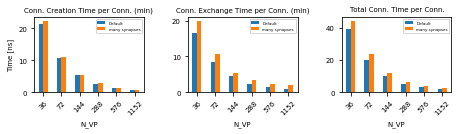

In [118]:
hpc_cases = time_per_connection(hpc_cases)
values = ['Conn. Creation Time per Conn. (min)',
          'Conn. Exchange Time per Conn. (min)',
          'Total Conn. Time per Conn.']

hpc_synapse_cases_tpc__p = plot_compare(hpc_cases, 'benchmark_figures/hpc_synapse_cases_time_per_conn.pdf',
                                        values, legend_loc='upper right')
save_table_latex(hpc_synapse_cases_tpc__p.to_latex(), 'latex_tables/hpc_synapse_cases_time_per_conn_table.txt')

hpc_synapse_cases_tpc__p

## HPC benchmark with many synapses per neuron vs block Population model

Conn. Creation (min)            Conn. Exchange (min)             \
Case        many synapses population        many synapses population   
N_VP                                                                   
36                  55.78      44.25                49.72      39.58   
72                  55.91      44.43                53.33      40.50   
144                 55.52      46.16                54.99      41.46   
288                 55.37      48.49                65.72      43.75   
576                 54.80      53.36                96.50      54.05   
1152                54.48      64.57               156.48      96.74   

       Conn. Total            Memory per Rank             
Case many synapses population   many synapses population  
N_VP                                                      
36          110.99      86.77        2.836591   2.140162  
72          118.45      88.60        3.110994   2.186019  
144         121.10      91.95        2.962012   2.266728  
288         130.18      95.33        3.105962   2.171257  
576         161.45     110.80        3.447438   2.445374  
1152        221.62     172.28        3.565286   2.491581

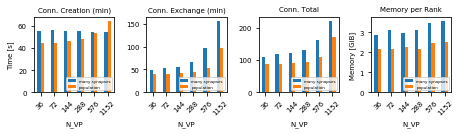

In [106]:
population['Case'] = ['population'] * len(population)

hpc_synapse_pop_cases = pd.concat([hpc_pop_comp, population])

hpc_synapse_pop_cases_p = plot_compare(hpc_synapse_pop_cases, 'benchmark_figures/hpc_synapse_vs_pop_cases.pdf')
save_table_latex(hpc_synapse_pop_cases_p.to_latex(), 'latex_tables/hpc_synapse_vs_pop_cases_table.txt')

hpc_synapse_pop_cases_p

#### time per connection

Conn. Creation Time per Conn. (min)             \
Case                       many synapses population   
N_VP                                                  
36                             22.329859  17.700000   
72                             11.190953   8.886000   
144                             5.556446   4.616000   
288                             2.770717   2.424500   
576                             1.371097   1.334000   
1152                            0.681545   0.807125   

     Conn. Exchange Time per Conn. (min)             \
Case                       many synapses population   
N_VP                                                  
36                             19.903919   15.83200   
72                             10.674540    8.10000   
144                             5.503403    4.14600   
288                             3.288631    2.18750   
576                             2.414432    1.35125   
1152                            1.957566    1.20925   

     Total Conn. Time per Conn.             
Case              many synapses population  
N_VP                                        
36                    44.431536    34.7080  
72                    23.708967    17.7200  
144                   12.119697     9.1950  
288                    6.514212     4.7665  
576                    4.039482     2.7700  
1152                   2.772468     2.1535

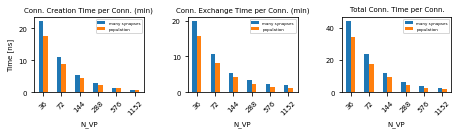

In [117]:
hpc_synapse_pop_cases = time_per_connection(hpc_synapse_pop_cases)
values = ['Conn. Creation Time per Conn. (min)',
          'Conn. Exchange Time per Conn. (min)',
          'Total Conn. Time per Conn.']

hpc_synapse_pop_tpc_cases_p = plot_compare(hpc_synapse_pop_cases,
                                           'benchmark_figures/hpc_synapse_vs_pop_cases_time_per_conn.pdf',
                                           values, legend_loc='upper right')
save_table_latex(hpc_synapse_pop_tpc_cases_p.to_latex(),
                 'latex_tables/hpc_synapse_vs_pop_cases_time_per_conn_table.txt')

hpc_synapse_pop_tpc_cases_p

## Compare nblocks and population

Conn. Creation Time per Conn. (min)                                \
Case                             NBLOCKS increasing NBLOCKS population   
N_VP                                                                     
36                             37.183821          37.183821  17.700000   
72                             18.853772          45.938216   8.886000   
144                             9.694696          77.503129   4.616000   
288                             5.081434         146.605880   2.424500   
576                             2.790176                NaN   1.334000   
1152                            1.652979                NaN   0.807125   

     Conn. Exchange Time per Conn. (min)                                \
Case                             NBLOCKS increasing NBLOCKS population   
N_VP                                                                     
36                             17.358005          17.262784   15.83200   
72                              8.744468           8.637345    8.10000   
144                             4.526969           4.388076    4.14600   
288                             2.421195           2.364396    2.18750   
576                             1.431292                NaN    1.35125   
1152                            0.962378                NaN    1.20925   

     Total Conn. Time per Conn.                                
Case                    NBLOCKS increasing NBLOCKS population  
N_VP                                                           
36                    55.819375          56.120909    34.7080  
72                    28.159648          57.505593    17.7200  
144                   14.793984          87.183434     9.1950  
288                    7.938066         166.895246     4.7665  
576                    4.422573                NaN     2.7700  
1152                   2.720248                NaN     2.1535

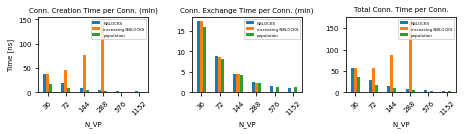

In [108]:
hpc_split_t6_s20['Case']          = ['NBLOCKS']*len(hpc_split_t6_s20)
hpc_split_increase_t6_s20['Case'] = ['increasing NBLOCKS']*len(hpc_split_increase_t6_s20)
population['Case']                = ['population']*len(population)

increasing_conns = pd.concat([hpc_split_t6_s20, hpc_split_increase_t6_s20, population])

increasing_conns = time_per_connection(increasing_conns)

values = ['Conn. Creation Time per Conn. (min)',
          'Conn. Exchange Time per Conn. (min)',
          'Total Conn. Time per Conn.']

increasing_conns_p = plot_compare(increasing_conns, 'benchmark_figures/nblocks_vs_population.pdf',
                                  values=values, legend_loc='upper right')
save_table_latex(increasing_conns_p.to_latex(), 'latex_tables/nblocks_vs_population.txt')

increasing_conns_p

## Multi-Area Model

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,T_sim,connections,ini,other
N_VP,,,,,,,
36,120.324007,34.458346,154.782448,1082.365881,2.551994,0.063860,-5.551115e-17
72,161.378545,42.557043,203.935915,1390.129490,2.550975,0.067006,2.189128e-02
144,245.404073,44.667060,290.071874,1664.842568,2.553382,0.171119,7.039388e-03
288,411.967277,46.147448,458.115551,2055.187021,2.626202,0.254059,-2.220446e-16
576,743.367733,36.390803,779.763724,60.539340,2.677456,0.106130,-5.551115e-17
1152,1461.262587,65.228588,1526.492920,3346.249244,2.939487,0.453178,1.665335e-16


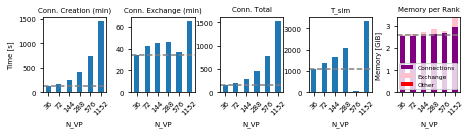

In [119]:
MAM_t6_s0_0625 = pd.read_csv('benchmark_results/MAM_conn_sort_update_daint_t6_s0_0625.csv')

MAM_t6_s0_0625['T_conns_min'] = MAM_t6_s0_0625['T_network_global_min'] + MAM_t6_s0_0625['T_connect_min']
MAM_t6_s0_0625['T_conns_max'] = MAM_t6_s0_0625['T_network_global_max'] + MAM_t6_s0_0625['T_connect_max']

MAM_t6_s0_0625 = calculate_T_conn_and_memory(MAM_t6_s0_0625)
MAM_t6_s0_0625_p = plot_results(MAM_t6_s0_0625, 'benchmark_figures/multi-area-model.pdf', plot_T_sim=True)

save_table_latex(MAM_t6_s0_0625_p.to_latex(), 'latex_tables/multi-area-model_table.txt')
MAM_t6_s0_0625_p

## 4x4 mesocircuit

,NUMBER_OF_NODES,TASKS_PER_NODE,THREADS_PER_TASK,SCALE,NUM_VPS,hash,num_tasks,T_nrns,T_conns_avg,T_conns_min,...,T_bld_xn,T_bld_nx,Conn. Total,Conn. Creation (min),Conn. Exchange (min),N_VP,connections,ini,other,Memory per Rank
0,1,6,6,0.0625,36,acd429db3b9ab17b5f5391184e500dc6,6,0.55,169.435000,169.10,...,175.15,175.65,175.15,169.10,6.05,36,0.502441,0.112576,0.049678,0.664696
1,2,6,6,0.1250,72,acd429db3b9ab17b5f5391184e500dc6,12,0.94,193.399167,193.27,...,199.94,200.46,199.94,193.27,6.66,72,0.521647,0.103027,0.063959,0.688634
2,4,6,6,0.2500,144,acd429db3b9ab17b5f5391184e500dc6,24,2.18,227.260833,226.92,...,234.20,234.88,234.20,226.92,7.27,144,0.540202,0.123834,0.075698,0.739733
3,8,6,6,0.5000,288,acd429db3b9ab17b5f5391184e500dc6,48,3.88,330.619792,330.18,...,338.22,339.09,338.22,330.18,8.02,288,0.455751,0.173929,0.103053,0.732733
4,16,6,6,1.0000,576,acd429db3b9ab17b5f5391184e500dc6,96,7.97,519.575833,519.27,...,529.73,530.76,529.73,519.27,10.44,576,0.409619,0.233214,0.171115,0.813949
5,32,6,6,2.0000,1152,acd429db3b9ab17b5f5391184e500dc6,192,21.36,927.114583,926.42,...,940.37,942.03,940.37,926.42,13.87,1152,0.410835,0.363299,0.303653,1.077786


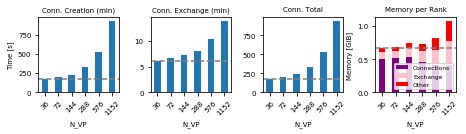

In [120]:
meso_t6_s0_0625 = pd.read_csv('benchmark_results/4x4_mesocircuit_conn_sort_update_daint_t6_s0_0625.csv')

meso_t6_s0_0625 = calculate_T_conn_and_memory(meso_t6_s0_0625)
meso_t6_s0_0625_p = plot_results(meso_t6_s0_0625, 'benchmark_figures/mesocircuit.pdf', plot_T_sim=False)

save_table_latex(meso_t6_s0_0625_p.to_latex(), 'latex_tables/mesocircuit_table.txt')
meso_t6_s0_0625

## Comapare hpc, population, MAM and 4x4

Conn. Creation Time per Conn. (min)                                   \
Case                                 4x4        MAM        hpc population   
N_VP                                                                        
36                            489.515902  79.768270  21.449937  17.700000   
72                            279.725388  53.492519  10.610413   8.886000   
144                           164.201195  40.672298   5.351623   4.616000   
288                           119.459960  34.138899   2.650135   2.424500   
576                            93.936412  30.800688   1.294453   1.334000   
1152                           83.794369  30.272964   0.646733   0.807125   

     Conn. Exchange Time per Conn. (min)                                   \
Case                                 4x4        MAM        hpc population   
N_VP                                                                        
36                             17.513727  22.844009  16.666166   15.83200   
72                              9.639215  14.106481   8.487145    8.10000   
144                             5.260632   7.402941   4.419360    4.14600   
288                             2.901656   3.824146   2.410650    2.18750   
576                             1.888605   1.507816   1.489744    1.35125   
1152                            1.254537   1.351340   0.976333    1.20925   

     Total Conn. Time per Conn.                                    
Case                        4x4         MAM        hpc population  
N_VP                                                               
36                   507.029629  102.612342  39.427591    34.7080  
72                   289.379076   67.599109  20.215483    17.7200  
144                  169.469064   48.075363  10.404012     9.1950  
288                  122.368853   37.963114   5.399026     4.7665  
576                   95.828635   32.308719   2.976772     2.7700  
1152                  85.056142   31.624340   1.724908     2.1535

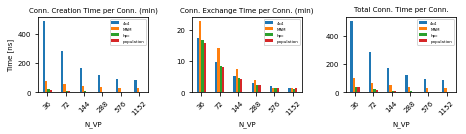

In [109]:
hpc_t6_s20['Case']      = ['hpc']*len(hpc_t6_s20)
MAM_t6_s0_0625['Case']  = ['MAM']*len(MAM_t6_s0_0625)
meso_t6_s0_0625['Case'] = ['4x4']*len(meso_t6_s0_0625)
population['Case']      = ['population']*len(population)

hpc_pop_MAM_4x4 = pd.concat([hpc_t6_s20, population, MAM_t6_s0_0625, meso_t6_s0_0625])

hpc_pop_MAM_4x4 = time_per_connection(hpc_pop_MAM_4x4)

values = ['Conn. Creation Time per Conn. (min)',
          'Conn. Exchange Time per Conn. (min)',
          'Total Conn. Time per Conn.']

hpc_pop_MAM_4x4_p = plot_compare(hpc_pop_MAM_4x4, 'benchmark_figures/hpc_population_MAM_4x4.pdf',
                                 values=values, legend_loc='upper right')
save_table_latex(hpc_pop_MAM_4x4_p.to_latex(), 'latex_tables/hpc_population_MAM_4x4_table.txt')

hpc_pop_MAM_4x4_p

## Different `Connect` rules
Compare different connection rules, `SCALE = 2 * NUMBER_OF_NODES`

**Compare *all* rules:**

Conn. Creation Time per Conn. (min)                                    \
Case                          all_to_all  bernoulli   indegree   outdegree   
N_VP                                                                         
36                             21.714455  29.226551  22.310631  120.510792   
72                             10.861248  14.467837  10.911102   95.045853   
144                             5.307987   7.234027   5.604309   83.807529   
288                             2.530716   4.118205   2.666428   79.137863   
576                             1.280828   2.770082   1.352966   76.866785   
1152                            0.640423   2.103520   0.669076   75.475271   

                         Conn. Exchange Time per Conn. (min)             \
Case symmetric bernoulli                          all_to_all  bernoulli   
N_VP                                                                      
36            333.393244                           15.792331  22.512344   
72            333.740431                            9.380168  11.702653   
144           344.262235                            4.937662   4.851489   
288           423.848498                            2.870202   2.617085   
576           629.921098                            1.342554   1.385041   
1152                 NaN                            0.725298   0.853012   

                                               Total Conn. Time per Conn.  \
Case   indegree  outdegree symmetric bernoulli                 all_to_all   
N_VP                                                                        
36    22.508070  19.891540           55.894720                  43.428910   
72    12.046646  12.162093           39.792128                  24.684654   
144    5.061160  13.551894           20.590555                  11.850389   
288    2.700993   7.875299           11.914983                   6.234202   
576    1.449254   4.667450            6.597118                   3.016889   
1152   0.849307   2.565192                 NaN                   1.547046   

                                                            
Case  bernoulli   indegree   outdegree symmetric bernoulli  
N_VP                                                        
36    55.688429  51.926513  173.506501          423.259314  
72    28.343135  25.179465  174.190222          396.341447  
144   13.344681  11.751766  131.906315          390.183617  
288    7.278458   5.994526  103.907477          440.953140  
576    4.429169   3.128116   95.369566          653.489995  
1152   3.192314   1.689973   88.111517                 NaN

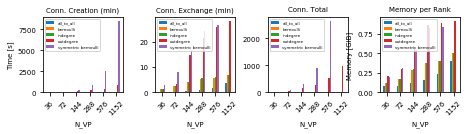

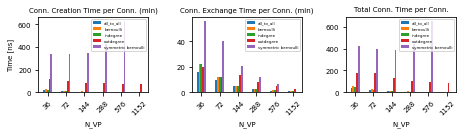

In [110]:
hpc_in = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s2_in.csv')
hpc_in['Case'] = ['indegree']*len(hpc_in)

hpc_out = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s2_out.csv')
hpc_out['Case'] = ['outdegree']*len(hpc_out)

hpc_bern = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s2_bern.csv')
hpc_bern['Case'] = ['bernoulli']*len(hpc_bern)

hpc_all = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s2_all.csv')
hpc_all['Case'] = ['all_to_all']*len(hpc_all)

hpc_sym = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s2_sym.csv')
hpc_sym['Case'] = ['symmetric bernoulli']*len(hpc_sym)

#hpc_one = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s2_one.csv')
#hpc_one['case'] = ['one_to_one']*len(hpc_one)

hpc_rules = pd.concat([hpc_in, hpc_out, hpc_bern, hpc_all, hpc_sym])#, hpc_one])

hpc_rules = calculate_T_conn_and_memory(hpc_rules)
hpc_rules = time_per_connection(hpc_rules)

values = ['Conn. Creation Time per Conn. (min)',
          'Conn. Exchange Time per Conn. (min)',
          'Total Conn. Time per Conn.']

hpc_rules_p = plot_compare(hpc_rules, 'benchmark_figures/hpc_rules_all.pdf', legend_loc='upper left')
save_table_latex(hpc_rules_p.to_latex(), 'latex_tables/hpc_rules_all_table.txt')
hpc_rules_p = plot_compare(hpc_rules, 'benchmark_figures/hpc_rules_all_time_per_connection.pdf',
                           values, legend_loc='upper right')
save_table_latex(hpc_rules_p.to_latex(), 'latex_tables/hpc_rules_all_time_per_connection_table.txt')

hpc_rules_p

**Compare *fixed_indegree, pairwise_bernoulli, all_to_all*:**

Conn. Creation Time per Conn. (min)                        \
Case                          all_to_all  bernoulli   indegree   
N_VP                                                             
36                             21.714455  29.226551  22.310631   
72                             10.861248  14.467837  10.911102   
144                             5.307987   7.234027   5.604309   
288                             2.530716   4.118205   2.666428   
576                             1.280828   2.770082   1.352966   
1152                            0.640423   2.103520   0.669076   

     Conn. Exchange Time per Conn. (min)                        \
Case                          all_to_all  bernoulli   indegree   
N_VP                                                             
36                             15.792331  22.512344  22.508070   
72                              9.380168  11.702653  12.046646   
144                             4.937662   4.851489   5.061160   
288                             2.870202   2.617085   2.700993   
576                             1.342554   1.385041   1.449254   
1152                            0.725298   0.853012   0.849307   

     Total Conn. Time per Conn.                        
Case                 all_to_all  bernoulli   indegree  
N_VP                                                   
36                    43.428910  55.688429  51.926513  
72                    24.684654  28.343135  25.179465  
144                   11.850389  13.344681  11.751766  
288                    6.234202   7.278458   5.994526  
576                    3.016889   4.429169   3.128116  
1152                   1.547046   3.192314   1.689973

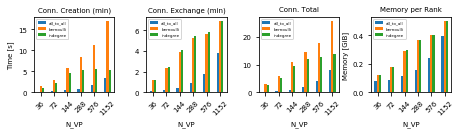

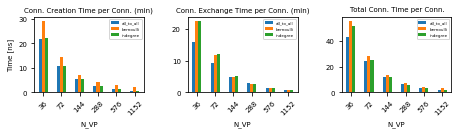

In [111]:
hpc_rules_few = pd.concat([hpc_in, hpc_bern, hpc_all])

hpc_rules_few = calculate_T_conn_and_memory(hpc_rules_few)
hpc_rules_few = time_per_connection(hpc_rules_few)

values = ['Conn. Creation Time per Conn. (min)',
          'Conn. Exchange Time per Conn. (min)',
          'Total Conn. Time per Conn.']

hpc_rules_few_p = plot_compare(hpc_rules_few, 'benchmark_figures/hpc_rules_fewer.pdf',
                               legend_loc='upper left')
save_table_latex(hpc_rules_few_p.to_latex(), 'latex_tables/hpc_rules_fewer_table.txt')
hpc_rules_few_p = plot_compare(hpc_rules_few, 'benchmark_figures/hpc_rules_fewer_time_per_connection.pdf',
                               values, legend_loc='upper right')
save_table_latex(hpc_rules_few_p.to_latex(), 'latex_tables/hpc_rules_fewer_time_per_connection_table.txt')

hpc_rules_few_p

## Fixed VP, different threads.

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
Threads,,,,,,
1,22.13,15.56,38.36,2.724609,0.234478,0.395222
3,39.30,33.40,81.39,2.743164,0.055838,0.099345
6,53.85,42.48,100.92,2.743245,0.019534,0.055941
9,56.42,66.25,124.45,2.742622,0.007792,0.045253
18,72.88,98.26,174.78,2.746012,0.031669,0.031951
32,104.03,108.28,212.31,2.759644,0.013889,0.026946


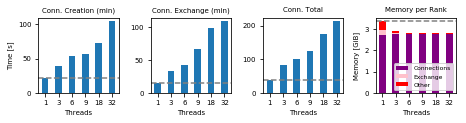

In [121]:
hpc_threads_n1 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_s20_threads.csv')

hpc_threads_n1 = calculate_T_conn_and_memory(hpc_threads_n1)

hpc_threads_n1['Threads'] = hpc_threads_n1['THREADS_PER_TASK']

hpc_threads_n1_p = plot_results(hpc_threads_n1, 'benchmark_figures/hpc_fixedVP_diff_threads_n1.pdf',
                                index='Threads', rot=0)

save_table_latex(hpc_threads_n1_p.to_latex(), 'latex_tables/hpc_fixedVP_diff_threads_n1_table.txt')
hpc_threads_n1_p

Conn. Creation (min)                       Conn. Exchange (min)  \
Case                    2.14   2.16     5g  master                 2.14   
Threads                                                                   
1                      48.96  27.44  20.58   26.59                 0.74   
3                      65.72  49.01  35.65   44.50                 1.14   
6                      71.94    NaN  46.75   58.02                 1.32   
9                      73.45    NaN  50.20   60.08                 1.18   
18                     75.75    NaN  63.14   76.86                 1.27   
36                     89.67    NaN  84.79  100.01                 1.88   

                               Conn. Total                         \
Case      2.16      5g  master        2.14   2.16      5g  master   
Threads                                                             
1          NaN   25.37   14.96       51.68    NaN   47.37   42.41   
3        40.79   32.34   33.05       72.07  96.08   73.83   85.81   
6          NaN   43.40   42.33       78.79    NaN   91.08  106.22   
9          NaN   46.54   64.84       77.40    NaN   97.98  130.10   
18         NaN   64.40   92.64       79.30    NaN  129.18  173.03   
36         NaN  134.14  104.20       91.55    NaN  218.93  204.21   

        Memory per Rank                                
Case               2.14      2.16        5g    master  
Threads                                                
1              3.131454       NaN  4.381996  3.354645  
3              2.838875  4.414881  3.916854  2.901877  
6              2.796472       NaN  3.829361  2.817963  
9              2.787800       NaN  3.809237  2.797168  
18             2.778902       NaN  3.789648  2.810139  
36             2.786571       NaN  3.783141  2.800488

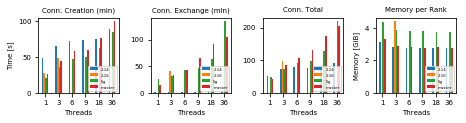

In [96]:
hpc_threads_214 = pd.read_csv('benchmark_results/hpc_benchmark_214_daint_threads.csv')
hpc_threads_214['Case'] = ['2.14']*len(hpc_threads_214)
hpc_threads_216 = pd.read_csv('benchmark_results/hpc_benchmark_216_daint_threads.csv')
hpc_threads_216['Case'] = ['2.16']*len(hpc_threads_216)
hpc_threads_m   = pd.read_csv('benchmark_results/hpc_benchmark_master_daint_threads.csv')
hpc_threads_m['Case']   = ['master']*len(hpc_threads_m)
hpc_threads_5g  = pd.read_csv('benchmark_results/hpc_benchmark_5g_daint_threads.csv')
hpc_threads_5g['Case']  = ['5g']*len(hpc_threads_5g)
# hpc_threads_3   = pd.read_csv('benchmark_results/hpc_benchmark_3_daint_threads.csv')
# hpc_threads_3['version']   = ['3']*len(hpc_threaDs_3)

hpc_threads = pd.concat([hpc_threads_214, hpc_threads_216, hpc_threads_m, hpc_threads_5g])

hpc_threads = calculate_T_conn_and_memory(hpc_threads)
hpc_threads['Threads'] = hpc_threads['THREADS_PER_TASK']
hpc_threads_p = plot_compare(hpc_threads, 'benchmark_figures/hpc_fixedVP_diff_threads_comparison.pdf',
                             index='Threads', rot=0)
save_table_latex(hpc_threads_n1_p.to_latex(), 'latex_tables/hpc_fixedVP_diff_threads_comparison.txt')

hpc_threads_p